In [1]:
!pip install pyDoe

  Preparing metadata (setup.py) ... done
  Created wheel for pyDoe: filename=pyDOE-0.3.8-py3-none-any.whl size=18171 sha256=2803695e3fa1bb6efd072155d889ff5a6d92e3933344029a07e731eef7cd13fd
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDoe


In [2]:
import numpy as np
import torch.cuda

from pyDOE import lhs
from torch import from_numpy

import matplotlib.pyplot as plt

def printMemory():
  t = torch.cuda.get_device_properties(0).total_memory
  r = torch.cuda.memory_reserved(0)
  a = torch.cuda.memory_allocated(0)
  f = r-a  # free inside reserved
  print(f"total: {t}, reserved: {r}, free: {f}")

# This file generates training data
def trainingData(lb, ub, num_bc, num_f, u, f, RNG_key = None):
  '''
    @param lb: 1d array specifying the lower bound of x and y
    @param ub: 1d array specifying the upper bound of x and y
    @param num_bc: number of points on each side of training region (total number of boundary points = 4 * num_bc)
    @param num_f: number of non-boundary interior points
    @param u: a method that takes in a 2d ndarray as input and returns value of u with given inputs
    @param f: a method that takes in [n * 2]tensors x, y as input and returns value of u_xx+u_yy with given inputs
    
    @return: boundary xy points and inside xy points concatenated, boundary xy points, boundary u values, interior xy points, u_xx+u_yy labels of the interior points
    '''
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
  if RNG_key != None:
      np.random.seed(RNG_key)
    
#   u = lambda xy: np.sin(xy[:, 0]) * np.cos([xy[:, 1]])
  # create edges on x={-2, 2}, y={-2, 2}
  leftedge_x_y = np.vstack((lb[0] * np.ones(num_bc), lb[1] + (ub[1] - lb[1]) * np.random.rand(num_bc) )).T
  leftedge_u = u(leftedge_x_y).T
  rightedge_x_y = np.vstack((ub[0] * np.ones(num_bc), lb[1] + (ub[1] - lb[1]) * np.random.rand(num_bc) )).T
  rightedge_u = u(rightedge_x_y).T
  topedge_x_y = np.vstack(( lb[0] + (ub[0] - lb[0]) * np.random.rand(num_bc), ub[1] * np.ones(num_bc) )).T
  topedge_u = u(topedge_x_y).T
  bottomedge_x_y = np.vstack((lb[0] + (ub[0] - lb[0]) * np.random.rand(num_bc), lb[1] * np.ones(num_bc) )).T
  bottomedge_u = u(bottomedge_x_y).T
    
  bc_x_y_train = np.vstack([leftedge_x_y, rightedge_x_y, bottomedge_x_y, topedge_x_y]) #x,y pairs on boundaries
  bc_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u]) #u values on boundaries
    
  # Latin Hypercube sampling for collocation points
  # num_f sets of tuples(x,t)
  inside_xy = lb + (ub-lb) * lhs(2, num_f)
  # HERE we want code that also generates the training labels (values of f) for the interior points 
  all_xy_train = np.vstack((inside_xy, bc_x_y_train)) # append training points to collocation points
  f_x_y = f(inside_xy[:,[0]], inside_xy[:,[1]])
  f_x_y = torch.from_numpy(f_x_y).to(device)
  
  all_xy_train = torch.from_numpy(all_xy_train).to(device)
  bc_x_y_train = torch.from_numpy(bc_x_y_train).to(device)
  bc_u_train = torch.from_numpy(bc_u_train).to(device)
  inside_xy = torch.from_numpy(inside_xy).to(device)

#   f_x_y = f(inside_xy[:,[0]], inside_xy[:,[1]])
    
  return all_xy_train, bc_x_y_train, bc_u_train, inside_xy, f_x_y

def testingData(lb, ub, u, f, num):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  X=np.linspace(lb[0], ub[0], num)
  Y=np.linspace(lb[1], ub[1], num)
    
  X, Y = np.meshgrid(X,Y) #X, Y are (256, 256) matrices

  U = u(X,Y)
  u_test = U.flatten('F')[:,None]
  u_test = torch.from_numpy(u_test).to(device)
  xy_test = np.hstack((X.flatten('F')[:,None], Y.flatten('F')[:,None]))
  x_test = xy_test[:,[0]]
  y_test = xy_test[:,[1]]

  f_test = f(xy_test[:,[0]], xy_test[:,[1]])
  f_test = torch.from_numpy(f_test).to(device)

  x_test = torch.from_numpy(xy_test[:,[0]]).to(device)
  y_test = torch.from_numpy(xy_test[:,[1]]).to(device)
  f_test = f(x_test, y_test)
  return x_test, y_test, xy_test, u_test, f_test, X, Y, U

def PINNplot(PINN, X, U, info):
    error_vec, u_pred = PINN.test(True)
    
    s=[1 for i in range(len(X[0]))]

    print('Test Error: %.5f'  % (error_vec))

    fig, (plts1, plts2) = plt.subplots(2, 5, figsize = (20,8))
    plts1[0].set_title("at Y=0, X and u_pred")
    plts1[0].set_xlabel("x")
    plts1[0].set_ylabel("u(x, 0)")
    plts1[0].scatter(X[0], u_pred[0], s=s, marker='.', label = "Predicted")
    plts1[0].scatter(X[0], U[0], s=s, marker='.', label = "Exact")
    plts1[0].legend(markerscale=4)

    plts1[1].set_title("at Y=0.25, X and true U")
    plts1[1].set_xlabel("x")
    plts1[1].set_ylabel("u(x, 0.25)")
    plts1[1].scatter(X[24], u_pred[24], s=s, marker='.', label = "Predicted")
    plts1[1].scatter(X[24], U[24], s=s, marker='.', label = "Exact")
    plts1[1].legend(markerscale=4)

    plts1[2].set_title("Iternation and L2 relative error")
    plts1[2].set_xlabel("Iternations")
    plts1[2].set_ylabel("L2 relative error ")
    plts1[2].scatter(info[:,0], info[:,1], marker='.')

    plts1[3].set_title("Iternation and PINN loss")
    plts1[3].set_xlabel("Iternations")
    plts1[3].set_ylabel("PINN loss")
    plts1[3].scatter(info[:,0], info[:,2], marker='.')

    plts1[4].set_title("Iternation and PINN PDE loss")
    plts1[4].set_xlabel("Iternations")
    plts1[4].set_ylabel("PINN PDE loss")
    plts1[4].scatter(info[:,0], info[:,3], marker='.')

    plts2[0].set_title("at Y=0.5, X and u_pred")
    plts2[0].set_xlabel("x")
    plts2[0].set_ylabel("u(x, 0.5)")
    plts2[0].scatter(X[50], u_pred[50], s=s, marker='.', label = "Predicted")
    plts2[0].scatter(X[50], U[50], s=s, marker='.', label = "Exact")
    plts2[0].legend(markerscale=4)

    plts2[1].set_title("at Y=1, X and true U")
    plts2[1].set_xlabel("x")
    plts2[1].set_ylabel("u(x, 1)")
    plts2[1].scatter(X[-1], u_pred[-1], s=s, marker='.', label = "Predicted")
    plts2[1].scatter(X[-1], U[-1], s=s, marker='.', label = "Exact")
    plts2[1].legend(markerscale=4)

    plts2[2].set_title("log10 L2 relative error and iterations")
    plts2[2].set_xlabel("Iternations")
    plts2[2].set_ylabel("log10 L2 relative error ")
    plts2[2].scatter(info[:,0], np.log10(info[:,1]), marker='.')

    plts2[3].set_title("Iternation and log10 PINN loss")
    plts2[3].set_xlabel("Iternations")
    plts2[3].set_ylabel("log10 PINN loss")
    plts2[3].scatter(info[:,0], np.log10(info[:,2]), marker='.')

    plts2[4].set_title("Iternation and log10 PINN PDE loss")
    plts2[4].scatter(info[:,0], np.log10(info[:,3]), marker='.')
    plts2[4].set_xlabel("Iternations")
    plts2[4].set_ylabel("log10 PINN PDE loss")

    fig.tight_layout()
def ACGDPlot(PINN, X, U, info):
    error_vec, u_pred = PINN.test(True)
    s=[1 for i in range(len(X[0]))]

    print('Test Error: %.5f'  % (error_vec))

    fig, (plts1, plts2) = plt.subplots(2, 6, figsize = (24,8))
    
    plts1[0].set_title("at Y=0, X")
    plts1[0].scatter(X[0], u_pred[0], s=s, marker='.', label = "Predicted u")
    plts1[0].scatter(X[0], U[0], s=s, marker='.', label = "Exact u")
    plts1[0].legend()

    plts1[1].set_title("Forward Passes vs iterations")
    plts1[1].scatter(info[:,6], info[:,1], marker='.')
    plts1[1].set_xscale("log")
    plts1[1].set_yscale("log")
    plts1[1].set_xlabel("Forward passes")
    plts1[1].set_ylabel("log10 L2 relative error")

    plts1[2].set_title("log10 L2 error vs log10 iterations")
    plts1[2].scatter(info[:,0], info[:,1], marker='.')
    plts1[2].set_xlim([90, info[-1:,0]+100])
    plts1[2].set_xscale("log")
    plts1[2].set_yscale("log")
    plts1[2].set_xlabel("log10 iterations")
    plts1[2].set_ylabel("log10 L2 relative error")

    plts1[3].set_title("log10 composite loss vs log10 iterations")
    plts1[3].scatter(np.log10(info[:,0]), np.log10(info[:,2]), marker='.')
    plts1[3].set_xlabel("log10 iterations")
    plts1[3].set_ylabel("log10 L2 composite loss")
    
    plts1[4].set_title("log10 PINN loss vs log10 iterations")
    plts1[4].scatter(np.log10(info[:,0]), np.log10(info[:,3]), marker='.')
    plts1[4].set_xlabel("log10 iterations")
    plts1[4].set_ylabel("log10 PINN loss")

    plts1[5].set_title("log10 PINN PDE loss vs log10 iterations")
    plts1[5].scatter(np.log10(info[:,0]), np.log10(info[:,4]), marker='.')
    plts1[5].set_xlabel("log10 iterations")
    plts1[5].set_ylabel("log10 pde loss")

    plts2[0].set_title("at Y=0.5, X")
    plts2[0].scatter(X[128], u_pred[128], s=s, marker='.', label = "Predicted u")
    plts2[0].scatter(X[128], U[128], s=s, marker='.', label = "Exact u")
    plts2[0].legend()

    plts2[1].set_title("Forward Passes vs iterations")
    plts2[1].scatter(info[:,6], info[:,1], marker='.')
    plts2[1].set_yscale("log")
    plts2[1].set_xlabel("Forward passes")
    plts2[1].set_ylabel("log10 L2 relative error")


    plts2[2].set_title("log(10) L2 relative error (PINN)")
    plts2[2].scatter(info[:,0], np.log10(info[:,1]), marker='.')
    plts2[2].set_xlabel("iterations")
    plts2[2].set_ylabel("log10 L2 relative error")

    plts2[3].set_title("Iternation and log(10) total loss ")
    plts2[3].scatter(info[:,0], np.log10(info[:,2]), marker='.')
    plts2[3].set_xlabel("Iterations")
    plts2[3].set_ylabel("log10 composite loss")

    plts2[4].set_title("Iternation and log(10) PINN loss ")
    plts2[4].scatter(info[:,0], np.log10(info[:,3]), marker='.')
    plts2[4].set_xlabel("iterations")
    plts2[4].set_ylabel("log10 PINN loss")

    plts2[5].set_title("Iternation and log(10) PINN PDE loss ")
    plts2[5].scatter(info[:,0], np.log10(np.abs(info[:,4])), marker='.')
    plts2[5].set_xlabel("iterations")
    plts2[5].set_ylabel("log10 PDE loss")

    fig.tight_layout()
    
    
def performancePlot(ax, info, modelType, label = ""):
    ax[0][0].scatter(np.log10(info[:,0]), np.log10(info[:,1]), s=[6 for i in info[:, 0]], label = label)
    
    ax[1][0].scatter(info[:,0], np.log10(info[:,1]), s=[6 for i in info[:, 0]], label = label)
    
    ax[0][0].set_xlabel("log10 training iterations")
    ax[0][0].set_ylabel("log10 relative L2 error")
    ax[0][1].set_xlabel("log10 training iterations")
    ax[0][1].set_ylabel("log10 PINN loss")
    ax[0][2].set_xlabel("log10 training iterations")
    ax[0][2].set_ylabel("log10 PDE loss")
    
    ax[1][0].set_xlabel("training iterations")
    ax[1][0].set_ylabel("log10 relative L2 error")
    ax[1][1].set_xlabel("training iterations")
    ax[1][1].set_ylabel("log10 PINN loss")
    ax[1][2].set_xlabel("training iterations")
    ax[1][2].set_ylabel("log10 PDE loss")
    
#     plts1[0].legend(loc = 4, markerscale=4)

#     plts1[1].set_title("Log 10 Iternation and log(10) PINN loss")
    if label == "Adam" or label == "SGD":
        ax[0][1].scatter(np.log10(info[:,0]), np.log10(info[:,2]), s=[6 for i in info[:, 0]], label = label)
    
        ax[0][2].scatter(np.log10(info[:,0]), np.log10(info[:,3]), s=[6 for i in info[:, 0]], label = label)
        
        ax[1][1].scatter(info[:,0], np.log10(info[:,2]), s=[6 for i in info[:, 0]], label = label)
        
        ax[1][2].scatter(info[:,0], np.log10(info[:,3]), s=[6 for i in info[:, 0]], label = label)
        
    else:
        ax[0][1].scatter(np.log10(info[:,0]), np.log10(info[:,3]), s=[6 for i in info[:, 0]], label = label)
        ax[0][2].scatter(np.log10(info[:,0]), np.log10(info[:,4]), s=[6 for i in info[:, 0]], label = label)
        
        ax[1][1].scatter(info[:,0], np.log10(info[:,3]), s=[6 for i in info[:, 0]], label = label)
        ax[1][2].scatter(info[:,0], np.log10(info[:,4]), s=[6 for i in info[:, 0]], label = label)

    
    for i in ax:
        for j in i:
            j.legend(markerscale = 4)

# plts2[0].set_title("Iternation and log(10) L2 relative error ")



In [3]:
import numpy as np
import time
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 
    
lb = np.array([-2, -2])
ub = np.array([2, 2])

num_bc = 50
num_f= 5000

import argparse
parser = argparse.ArgumentParser(description='Enter the parameters')
parser.add_argument('-tol','--tol', help='relative tolerance for GMRES', type = float, required=True)
parser.add_argument('-atol','--atol', help='absolute tolerance for GMRES', type = float, required=True)

args = parser.parse_args(["--tol","5e-4",'--atol',"5e-4"])

#args = parser.parse_args(["--lrmax","5e-4",'--lrmin',"5e-4",'--pinn',"3","5",'--dis','4',"50"])
tol = args.tol
atol = args.atol
#g_iter = args.g_iter

tol = 1e-7
atol = 1e-20
g_iter =  10
# '
path = f"Poisson/output/1_dis_GACGD_tol_{tol}_atol_{atol}_g_iter_{g_iter}"

# isDirectory = os.path.isdir(path)

# if not os.path.isdir(path):
#     os.makedirs(path)
    
if not os.path.isdir(path + "/history"):
    os.makedirs(path + "/history")
    
if not os.path.isdir(path + "/zz"):
    os.makedirs(path + "/zz")
    
# if not os.path.isdir(path + "/prediction"):
#     os.makedirs(path + "/prediction")'
        
        
        
u = lambda xy: np.sin(xy[:, 0]) * np.cos([xy[:, 1]]) # this cannot be a torch function, otherwise the gradient would be recorded
f = lambda x, y: -2 * np.sin(x) * np.cos(y) #torch->np 

RNG_key = 3

all_xy_train, xy_bc, u_bc, xy_inside, f_xy = trainingData(lb, ub, num_bc, num_f, u, f, RNG_key)

u_test_method = lambda x, y: np.sin(x) * np.cos(y) #takes 2 inputs, but should return same values as previous u
x_test, y_test, xy_test, u_test, f_test, X, Y, U = testingData(lb, ub, u_test_method, f, 256)





cpu


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [4]:
!pip install CGDs

In [5]:
# This is supposed to be a template for how to implement PINNS models for the code
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import math
import matplotlib.pyplot as plt


# This class represents a PINN solving a Poisson problem in 2 dimensions
class PINN_Poisson_2d(nn.Module):
    def __init__(self, layers, x_test, y_test, u_test, f_test, x_bc, y_bc, u_bc, fxy, x_inside_train, y_inside_train, RNG_key = None):
        '''
        @param layers: number of input/output neurons in each layer of the model
        @param x_test: n*1 tensor, used for testing
        @param y_test: n*1 tensor, used for testing
        @param u_test: n*1 tensor, used for testing
        @param f_test: n*1 tensor, used for testing
        
        @param x_bc: n*1 tensor, used in determining boundary losses
        @param y_bc: n*1 tensor, used in determining boundary losses
        @param u_bc: n*1 tensor, used in determining boundary losses
        
        @param fxy: n*1 tensor, used in determining interior points' PDE losses in training
        @param x_inside_train: n*1 tensor, used in determining interior points' PDE losses
        @param y_inside_train: n*1 tensor, used in determining interior points' PDE losses
        
        '''
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function as MSE'
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0 
        self.layers = layers
        
        self.x_test = x_test #used for testing
        self.y_test = y_test
        self.u_test = u_test
        self.f_test = f_test
        
        self.x_bc = x_bc #boundaries
        self.y_bc = y_bc
        self.u_bc = u_bc
        self.x_inside_train = x_inside_train #for interior poitns PDE training
        self.y_inside_train = y_inside_train
        self.fxy = fxy #u_xx+u_yy
        
        if RNG_key == None:
            torch.manual_seed(1234)
            torch.cuda.manual_seed_all(1234)
        else:
            torch.manual_seed(RNG_key)
            torch.cuda.manual_seed_all(RNG_key)

        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        'foward pass'
    def forward(self, x, y):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x).to(device)
        if torch.is_tensor(y) != True:         
            y = torch.from_numpy(y).to(device)
        
        a = torch.cat((x, y),1)
        # print(a.shape)

        for i in range(len(self.layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a

    def loss_BC(self, x_bc = None, y_bc = None, u_bc = None):
        '''
        the parameters must be all None or all non-None 
        '''
        if x_bc != None:
            return self.loss_function(self.forward(x_bc, y_bc), u_bc)
        else:
            return self.loss_function(self.forward(self.x_bc, self.y_bc), self.u_bc)
    
    # We do not want to hard code the right hand side. Instead, we want to pass it as a label, just like the boundary conditions
    def loss_PDE(self, x = None, y = None, fxy = None):
        '''
        the parameters must be all None or all non-None 
        '''
        shouldBeZero = self.test_PDE(self.x_inside_train, self.y_inside_train, self.fxy)
        
        if x !=  None:
            shouldBeZero = self.test_PDE(x, y, fxy)

        loss_f = self.loss_function(shouldBeZero, torch.zeros_like(shouldBeZero))
                
        return loss_f

    def test_PDE(self, x = None, y = None, fxy = None):
        '''
        the parameters must be all None or all non-None 
        '''
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        _x = self.x_inside_train.clone()
        _y = self.y_inside_train.clone()
        _fxy = self.fxy.clone()

        if x != None:
            _x = x.clone()
            _y = y.clone()
            _fxy = fxy.clone()
            
        _x.requires_grad = True
        _y.requires_grad = True
        
        u = self.forward(_x, _y)

        u_x = autograd.grad(u,_x,torch.ones([_x.shape[0], 1]).to(device), retain_graph= True, create_graph=True)[0]
        u_y = autograd.grad(u,_y,torch.ones([_y.shape[0], 1]).to(device),retain_graph= True, create_graph=True)[0]

        u_xx = autograd.grad(u_x,_x,torch.ones((_x.shape[0], 1)).to(device), create_graph = True)[0]
        u_yy = autograd.grad(u_y,_y,torch.ones((_y.shape[0], 1)).to(device), create_graph = True)[0]

        shouldBeZero = u_xx + u_yy - _fxy
        shouldBeZero.retain_graph = True
        
        return shouldBeZero

    def loss(self, x_bc = None, y_bc = None, u_bc = None, x_inside=None, y_inside=None, fxy=None):
        '''
            if no resampling is needed in training iterations, do not provide values for the parameters
        
            the first 3 parameters must be all None or all non-None 
            
            the last 3 parameters must be all None or all non-None 
        
        '''
        loss_u = 0
        loss_f = 0
        if x_bc != None:
            loss_u = self.loss_BC(x_bc, y_bc, u_bc)
        else:
            loss_u = self.loss_BC()
            
        if x_inside != None:
            loss_f = self.loss_PDE(x_inside, y_inside, fxy)
        else:
            loss_f = self.loss_PDE()
        
        loss_val = loss_u + loss_f

        return loss_val, loss_u, loss_f
         
    # I am not sure this function should be part of the neural network, and if it is, it should again work with a general f
    # 'test neural network'
    def test(self, graph = False):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        _x = self.x_test.clone()
        _y = self.y_test.clone()
        _x.requires_grad = True
        _y.requires_grad = True
        
        u_pred = self.forward(_x, _y)
        
        u_x = autograd.grad(u_pred,_x,torch.ones([_x.shape[0], 1]).to(device), retain_graph= True, create_graph=True)[0]      
        u_y = autograd.grad(u_pred,_y,torch.ones([_y.shape[0], 1]).to(device), retain_graph= True, create_graph=True)[0]

        u_xx = autograd.grad(u_x, _x, torch.ones((_x.shape[0], 1)).to(device) , retain_graph = True)[0]
        u_yy = autograd.grad(u_y, _y, torch.ones((_y.shape[0], 1)).to(device) , retain_graph = True)[0]

        fxy_test = self.f_test
        
        PDE = u_xx + u_yy - fxy_test
        
        test_size = int(math.sqrt(self.x_test.shape[0]))
        
        PDE = PDE.cpu().detach().numpy()
        
        PDE = np.reshape(PDE, (test_size, test_size), order='F') #PDE is a 256*256 matrix now

        u_pred = u_pred.cpu().detach().numpy()
        
        error_vec = np.linalg.norm((self.u_test.cpu().detach().numpy() - u_pred),2) / np.linalg.norm(self.u_test.cpu().detach().numpy(), 2)  # Relative L2 Norm of the error (Vector)
        
        u_pred = np.reshape(u_pred, (test_size, test_size), order='F')
        u_test_graph = np.reshape(self.u_test.cpu().detach().numpy(),(test_size, test_size), order='F') # make u_test a matrix for graphing
        if (graph):
          fig, ax = plt.subplots(1, 4,figsize=(30,4))
          
          im1 = ax[0].imshow(u_test_graph, interpolation='nearest', cmap='rainbow', 
#                       extent=[self.y_test.min(), self.y_test.max(), self.x_test.min(), self.x_test.max()], 
                      origin='lower', aspect='equal')
          fig.colorbar(im1, ax = ax[0])
          
          im2 = ax[1].imshow(u_pred, interpolation='nearest', cmap='rainbow', 
#                       extent=[self.y_test.min(), self.y_test.max(), self.x_test.min(), self.x_test.max()], 
                      origin='lower', aspect='equal')
          fig.colorbar(im2, ax = ax[1])
          
          im3 = ax[2].imshow(u_pred - u_test_graph, interpolation='nearest', cmap='bwr', 
#                       extent=[self.y_test.min(), self.y_test.max(), self.x_test.min(), self.x_test.max()], 
                      origin='lower', aspect='equal')
          fig.colorbar(im3, ax=ax[2])
          
          im4 = ax[3].imshow(PDE, interpolation='nearest', cmap='bwr', 
#                       extent=[self.y_test.min(), self.y_test.max(), self.x_test.min(), self.x_test.max()], 
                      origin='lower', aspect='equal')


          ax[0].set_title('True $u(x,y)$', fontsize = 10)
          ax[1].set_title('Predicted $u(x,y)$', fontsize = 10)
          ax[2].set_title('Difference', fontsize = 10)
          ax[3].set_title('PDE diff', fontsize = 10)

          fig.colorbar(im4, ax = ax[3])
          plt.show()
        return error_vec, u_pred

# The Discriminator Network
# A general discriminator. Input_size is the physical dimension of the problem, output_size the dimension of the residual
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map = nn.Sequential(
            nn.Linear(input_size, 2 * hidden_size),
            nn.ReLU(),
#             nn.Tanh(),
            nn.Linear(2 * hidden_size, 2 * hidden_size),
            nn.ReLU(),
#             nn.Tanh(),
            nn.Linear(2 * hidden_size, 2 * hidden_size),
            nn.ReLU(),
#             nn.Tanh(),
            nn.Linear(2 * hidden_size, 2 * hidden_size),
            nn.ReLU(),
#             nn.Tanh(),
            nn.Linear(2  * hidden_size, output_size),
        )

    def forward(self, x, y):
        return self.map(torch.cat((x,y), 1))

initialize networks

forward passes (2 ( CGD) + 5 * 2 (GERM)) + maxiter

In [6]:
10 ** 5 / 200

500.0

In [7]:

layers = np.array([2,50 ,50, 50,1])
g_iter = 100

'ACGD Optimizer'
import CGDs
#from training import trainACGD

PINNGACGD = PINN_Poisson_2d(layers, x_test, y_test, u_test, f_test,
                                xy_bc[:,[0]], xy_bc[:,[1]], u_bc, 
                                f_xy, xy_inside[:,[0]], xy_inside[:,[1]], RNG_key)

PINNGACGD.to(device)


D_GACGD = Discriminator(2, 50 ,2)
D_GACGD.to(device)

print(PINNGACGD)
print(D_GACGD)

lr = 0.001

track_cond = lambda x, y:  True
optimizer = CGDs.GACGD(x_params=D_GACGD.parameters(), y_params = PINNGACGD.parameters(), max_iter = g_iter,
            lr_x=lr, lr_y=lr, tol=tol, atol = atol, eps=1e-8, beta=0.99, track_cond = track_cond)




PINN_Poisson_2d(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
Discriminator(
  (map): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)


forward passes() (2* CGD + 1000 *2) Germ +

optimales germ

In [8]:
10 ** 5 / 12

8333.333333333334

In [9]:
(10 ** 5 ) / 40

2500.0

In [10]:
15 * 10000 

150000

In [11]:
5000 / 12

416.6666666666667

In [12]:
589 / 60

9.816666666666666

In [13]:
max_iter = 2000
recordPer = 1
savePer = 50
graphPer = 0

GACGDInfo = []
iter_num_sum = 0
start_time = time.time()

ACGDInfo = pd.DataFrame()
re_pinn = []
gmre = []
for e in range(max_iter):
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    D_output = D_GACGD(PINNGACGD.x_inside_train, PINNGACGD.y_inside_train) #output[0]=bc, output[1]=inside
    g_pde_diff = PINNGACGD.test_PDE()

    # Optimizer step
    loss1 = D_output[:,[0]] * g_pde_diff
    loss2 = D_GACGD(PINNGACGD.x_bc, PINNGACGD.y_bc)[:,[1]] * (PINNGACGD(PINNGACGD.x_bc, PINNGACGD.y_bc) - PINNGACGD.u_bc)

    loss_y = loss1.mean() + loss2.mean()
    
    loss_x = -loss_y
    optimizer.step(loss_x, loss_y, 0) #breaks at first step() call
    print(e) 
    gmre.append(optimizer.info['num_iter'])



    iter_num_sum += optimizer.info["num_iter"]
    if e % recordPer == 0:
        
    #   losses.append(loss.item())
        g_loss, loss_bc, g_pde_loss = PINNGACGD.loss()
        error_vec, u_pred = PINNGACGD.test(graphPer != 0 and e % graphPer == 0)
        re_pinn.append(g_loss.item())
                
        new_row = {
        "iter": e,
        "L2 error": error_vec,
        "PINN loss": g_loss.item(),
        #"PINN BC loss": loss_bc.item(),
        #"PINN PDE loss": g_pde_loss.item(),
        "CPINN loss": loss_y.item(),
        # "CPINN PDE loss": loss1.mean().item(),
        #"CPINN BC loss": loss2.mean().item(),
        "iter_num_sum" : iter_num_sum
        }
        ACGDInfo = pd.concat([ACGDInfo, pd.DataFrame([new_row])], ignore_index=True)

    if e % savePer == 0: 
        
        ACGDInfo.to_csv(f"{path}/history/ACGDInfo_{e}.csv")
       # np.savetxt(f"{path}/prediction/PINNPrediction_iter_{e}.csv", u_pred)
    #     torch.save({
    #         "PINN_state_dict": PINNGACGD.state_dict(),
    #         "Discriminator_state_dict": D_GACGD.state_dict(),
    #         "GACGD_optimizer_state_dict" : optimizer.state_dict(),
    #     }, f"{path}/zz/GACGD_zz_iter_{e}.pt")

print(f"Time: {time.time() - start_time}")

/usr/local/lib/python3.10/dist-packages/CGDs/gmres_torch.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  y, _ = torch.triangular_solve(beta[0:j + 1].unsqueeze(-1), H[0:j + 1, 0:j + 1])  # j x j


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
# new_row = {
# "iter": e,
# "L2 error": error_vec,
# "PINN loss": g_loss.item(),
# #"PINN BC loss": loss_bc.item(),
# #"PINN PDE loss": g_pde_loss.item(),
# "CPINN loss": loss_y.item(),
# # "CPINN PDE loss": loss1.mean().item(),
# #"CPINN BC loss": loss2.mean().item(),
# "iter_num_sum" : iter_num_sum
# }
# ACGDInfo = pd.concat([ACGDInfo, pd.DataFrame([new_row])], ignore_index=True)
# ACGDInfo

forward passes

In [15]:
300 * 2 + sum(gmre) *2

349896

In [16]:
ACGDInfo.to_csv(f"{path}/ACGDInfo_{e}.csv")
# np.savetxt(f"{path}/prediction/PINNPrediction_iter_{e}.csv", u_pred)
torch.save({
    "PINN_state_dict": PINNGACGD.state_dict(),
    "Discriminator_state_dict": D_GACGD.state_dict(),
    "GACGD_optimizer_state_dict" : optimizer.state_dict(),
}, f"{path}/GACGD_zz_iter_{e}.pt")

In [17]:
5000 / 17

294.11764705882354

In [18]:
#
#GERM 1000 (2* CGD + 1000 *2)

In [19]:
# torch.save({
#             "PINN_state_dict": PINNGACGD.state_dict(),
#             "Discriminator_state_dict": D_GACGD.state_dict(),
#             "GACGD_optimizer_state_dict" : optimizer.state_dict(),
#         }, f"{path}/zz/GACGD_zz_iter_{e}.pt")

In [20]:
# num = 2000
# error_vec = np.linalg.norm((self.u_test.cpu().detach().numpy() - u_pred),2) / np.linalg.norm(self.u_test.cpu().detach().numpy(), 2)  # Relative L2 Norm of the error (Vector)

In [21]:
#z_1 = pd.read_csv("D:\\ARBEIT\\pinn\\CPINN\\Poisson\\Poisson\\output\\1_dis_GACGD_tol_1e-07_atol_1e-20_g_iter_1000\\history\\ACGDInfo_1576.csv")

In [22]:

def testingData(lb, ub, u, f, num):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  X=np.linspace(lb[0], ub[0], num)
  Y=np.linspace(lb[1], ub[1], num)
    
  X, Y = np.meshgrid(X,Y) #X, Y are (256, 256) matrices

  U = u(X*Y)
  u_test = U.flatten('F')[:,None]
  u_test = torch.from_numpy(u_test).to(device)
  xy_test = np.hstack((X.flatten('F')[:,None], Y.flatten('F')[:,None]))
  x_test = xy_test[:,[0]]
  y_test = xy_test[:,[1]]
  
  f_test = f(xy_test[:,[0]], xy_test[:,[1]])
  # f_test = torch.from_numpy(f_test).to(device)

  # x_test = torch.from_numpy(xy_test[:,[0]]).to(device)
  # y_test = torch.from_numpy(xy_test[:,[1]]).to(device)
#   f_test = f(x_test, y_test)
  return x_test, y_test, xy_test, u_test, f_test, X, Y, U

In [23]:
hist = ACGDInfo['PINN loss']

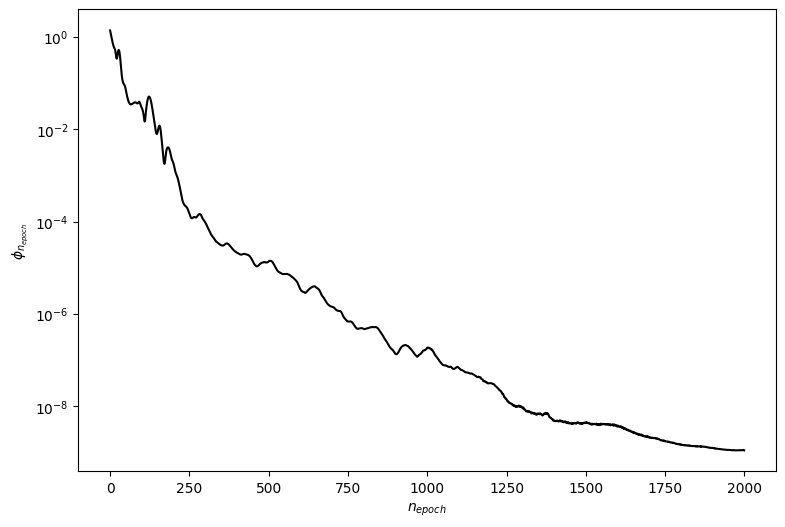

In [24]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

In [25]:
def test(PINN):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    _x = PINN.x_test.clone()
    _y = PINN.y_test.clone()
    _x.requires_grad = True
    _y.requires_grad = True
    
    u_pred = PINN.forward(_x, _y)
    
    test_size = int(np.sqrt(PINN.x_test.shape[0]))


    u_pred = u_pred.cpu().detach().numpy()
    
    error_vec = np.linalg.norm((PINN.u_test.cpu().detach().numpy() - u_pred),2) / np.linalg.norm(PINN.u_test.cpu().detach().numpy(), 2)  # Relative L2 Norm of the error (Vector)
    
    u_pred = np.reshape(u_pred, (test_size, test_size), order='F')
    u_test_graph = np.reshape(PINN.u_test.cpu().detach().numpy(),(test_size, test_size), order='F') # make u_test a matrix for graphing

    return error_vec, u_pred

#plot mit PiNN DISC LÖSUNG


$\| NN(x,y) -  u(x,y) \|_2$

In [26]:
test(PINNGACGD)[0]

5.463543242711991e-06

In [27]:
ACGDInfo['PINN loss']

0       1.396957e+00
1       1.290143e+00
2       1.169834e+00
3       1.078231e+00
4       1.000151e+00
            ...     
1995    1.109682e-09
1996    1.115971e-09
1997    1.130256e-09
1998    1.114741e-09
1999    1.107977e-09
Name: PINN loss, Length: 2000, dtype: float64

In [28]:
# gs1 = gridspec.GridSpec(1, 3)
# gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

# ax = plt.subplot(gs1[0, 0])
# ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
# ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
# ax.set_xlabel('$x$')
# ax.set_ylabel('$|h(t,x)|$')    
# #ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
# ax.axis('square')
# ax.set_xlim([-5.1,5.1])
# ax.set_ylim([-0.1,5.1])

In [29]:
# def test(PINN, graph = False):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     _x = PINN.x_test.clone()
#     _y = PINN.y_test.clone()
#     _x.requires_grad = True
#     _y.requires_grad = True
    
#     u_pred = PINN.forward(_x, _y)
    
#     u_x = torch.autograd.grad(u_pred,_x,torch.ones([_x.shape[0], 1]).to(device), retain_graph= True, create_graph=True)[0]      
#     u_y = torch.autograd.grad(u_pred,_y,torch.ones([_y.shape[0], 1]).to(device), retain_graph= True, create_graph=True)[0]

#     u_xx = torch.autograd.grad(u_x, _x, torch.ones((_x.shape[0], 1)).to(device) , retain_graph = True)[0]
#     u_yy = torch.autograd.grad(u_y, _y, torch.ones((_y.shape[0], 1)).to(device) , retain_graph = True)[0]

#     fxy_test = PINN.f_test
    
#     #PDE = u_xx + u_yy - fxy_test
    
#     test_size = int(math.sqrt(PINN.x_test.shape[0]))
    
#     #PDE = PDE.cpu().detach().numpy()
    
#    # PDE = np.reshape(PDE, (test_size, test_size), order='F') #PDE is a 256*256 matrix now

#     u_pred = u_pred.cpu().detach().numpy()
    
#     error_vec = np.linalg.norm((PINN.u_test.cpu().detach().numpy() - u_pred),2) / np.linalg.norm(PINN.u_test.cpu().detach().numpy(), 2)  # Relative L2 Norm of the error (Vector)
    
#     u_pred = np.reshape(u_pred, (test_size, test_size), order='F')
#     u_test_graph = np.reshape(PINN.u_test.cpu().detach().numpy(),(test_size, test_size), order='F') # make u_test a matrix for graphing
#     if (graph):
#         fig, ax = plt.subplots(1, 3,figsize=(30,4))
        
#         im1 = ax[0].imshow(u_test_graph, interpolation='nearest', cmap='rainbow', 
# #                       extent=[PINN.y_test.min(), PINN.y_test.max(), PINN.x_test.min(), PINN.x_test.max()], 
#                     origin='lower', aspect='equal')
#         fig.colorbar(im1, ax = ax[0])
        
#         im2 = ax[1].imshow(u_pred, interpolation='nearest', cmap='rainbow', 
# #                       extent=[PINN.y_test.min(), PINN.y_test.max(), PINN.x_test.min(), PINN.x_test.max()], 
#                     origin='lower', aspect='equal')
#         fig.colorbar(im2, ax = ax[1])
        
#         im3 = ax[2].imshow(u_pred - u_test_graph, interpolation='nearest', cmap='bwr', 
# #                       extent=[PINN.y_test.min(), PINN.y_test.max(), PINN.x_test.min(), PINN.x_test.max()], 
#                     origin='lower', aspect='equal')
#         fig.colorbar(im3, ax=ax[2])
        
# #         im4 = ax[3].imshow(PDE, interpolation='nearest', cmap='bwr', 
# # #                       extent=[PINN.y_test.min(), PINN.y_test.max(), PINN.x_test.min(), PINN.x_test.max()], 
# #                     origin='lower', aspect='equal')


#         ax[0].set_title('True $u(x,y)$', fontsize = 10)
#         ax[1].set_title('Predicted $u(x,y)$', fontsize = 10)
#         ax[2].set_title('Difference', fontsize = 10)
#        # ax[3].set_title('PDE diff', fontsize = 10)

#         #fig.colorbar(im4, ax = ax[3])
#         plt.show()
#     return error_vec, u_pred

In [30]:
# import math
# test(PINNGACGD,True)